# Executive Summary

The West Nile Virus (WNV), which first originated in the West Nile area (Uganda) of Africa in 1937, recently made its way to the United States. The major vector for WNV are the mosquito species *Culex Pipiens* and *Culex Restuans*. The pathogen is further amplified by birds when they get bitten by an infected mosquito. A large majority (about 80%) of people infected with WNV are asymptomatic. In general, the illness is not life threatening with those who exhibit symptoms experiencing fevers and aches and then fatigue which may last for several weeks. However those aged 60 and above are at an increased risk of developing complications in the central nervous system, which can lead to permanent damage or even death.

The windy city, Chicago, is ranked as one of the worst cities in USA for mosquito infestation. As such, the risk of transmission and propagation of WNV is a matter of serious concern. Each year, Chicago's Department of Public Health deploys workers to set up mosquito traps throughout the city to collect mosquitos to test for the presence of WNV. 

A new data science team was formed within the Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE) to utilize the collected data, along with data from the 2 weather stations in Chicago, to predict when WNV outbreaks are likely to occur each year. A predictive model was developed using Adaptive Boost Classifier and optimized for sensitivity.

The project is divided into two separate notebooks:
- Data Cleaning and EDA
- Modelling and Evaluation

This notebook is for **Modelling and Evaluation**.

# Contents
- [Problem Statement](#problem)
- [Pre-processing](#preprocess)
- [Gridsearch Cross Validation](#gs)
- [Model Evaluation](#eval)
    * [Model 1: Logistic Regression](#lr)
    * [Model 2: Random Forest Classifier](#rf)
    * [Model 3: Adaptive Boosting Classifier](#ada)
    * [Model 4: Gradient Boosting Classifier](#gb)
    * [Model 5: Neural Network - Multi Layer Perceptron Classifier](#nn)
- [Kaggle Evaluation](#kaggle)
- [Conclusions and Recommendations](#conclude)

<a id='problem'></a>
# Problem Statement

With the recent rise in cases of WNV in Chicago, DATA-SCIENCE has initiated a project to construct a machine learning model to predict the occurence of WNV in the City. Current pesticide application practices do not appear to be effective in curbing the spread of the virus. This project aims to use the findings from machine learning to devise a more effective strategy to annual pesticide application in Chicago.

- Accurately predict the occurance of WNV
- Optimize model for sensitivity
- Recommend spraying strategy

### Stakeholders

- Disease and Treatment Agency, division of Societal Cures in Epidemiology and New Creative Engineering (DATA-SCIENCE)
- Department of Public Health Chicago
- Chicago Citizens

## Modelling Process Summary

In [1]:
# Import libraries 

# Data Manipulation
import numpy as np 
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt

# Machine LearningI
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (confusion_matrix , accuracy_score, roc_auc_score, plot_roc_curve, 
                             precision_score, recall_score, make_scorer, f1_score, classification_report)




# Options
pd.set_option('display.max_columns', 200)

#### Import model features

In [2]:
train_df = pd.read_csv('../../datasets/train_df.csv')
test_df = pd.read_csv('../../datasets/test_df.csv')

In [3]:
#Drop non predictive features
train_df.drop(columns = ['latitude','longitude','nummosquitos','trap','date'], inplace = True)
test_df.drop(columns = ['latitude','longitude','trap','date'],inplace = True)

<a id='preprocess'></a>
## Pre-processing
### Train/test split

In [4]:
target = 'wnvpresent'

X = train_df.drop('wnvpresent', axis = 1)
y = train_df[target]
X_test = test_df[X.columns]

X_train, X_holdout, y_train, y_holdout  = train_test_split(X, y, random_state = 25, train_size = 0.75, stratify=y)

In [5]:
X.columns

Index(['culex_pipiens', 'culex_pipiens/restuans', 'culex_restuans', 'tavg',
       'depart', 'dewpoint', 'cool', 'weathertype_vc', 'weathertype_dz',
       'weathertype_ra', 'weathertype_hz', 'weathertype_br', 'weathertype_fg',
       'weathertype_ts', 'daylighthours', 'relative_humidity',
       'preciptotal_roll1_lag10', 'stnpressure_roll7_lag28',
       'sealevel_roll7_lag28', 'resultspeed_roll7_lag28'],
      dtype='object')

In [6]:
fix_cols = [x for x in X_train.columns if x.startswith('culex') or x.startswith('weathertype') or x.startswith('wnvpresent')]
cols = [x for x in X_train.columns if x not in fix_cols]

In [7]:
cols

['tavg',
 'depart',
 'dewpoint',
 'cool',
 'daylighthours',
 'relative_humidity',
 'preciptotal_roll1_lag10',
 'stnpressure_roll7_lag28',
 'sealevel_roll7_lag28',
 'resultspeed_roll7_lag28']

### Data Transfomation
- Standard Scaler
    * Performed only on numerical features, excluding non-binary features
- SMOTE (Synthetic Minority Over-sampling Technique)
    * Uses synthetic data generation to increase the number of samples in the data set to make classes more balanced

In [8]:
# Standard Scaler
ss = StandardScaler()

for i in cols:
    X_train.loc[:,i] = ss.fit_transform(X_train[[i]])
    X_holdout.loc[:,i] = ss.transform(X_holdout[[i]])

C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on 

In [9]:
# SMOTE
sm = SMOTE(random_state = 25)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
X_holdout_sm, y_holdout_sm = sm.fit_resample(X_holdout, y_holdout)

<a id='gs'></a>
## Gridsearch Cross Validation

In this section, we set up the gridsearch cross validation for our desired models and hyperparameters. We will comment on the choice of hyperparameters and results of the gridsearch in a later section

In [10]:
#Function which performs gridsearching over different pipelines
#inputs are lists containing models and respective parameters for each pipeline
#outputs are lists containing the cross validated score and best parameters for each pipeline

def gridsearcher(models,parameters,X,y):
    cross_val_scores = []
    best_params = []
    
    for n, p in enumerate(parameters):
        gs = GridSearchCV(models[n],
                         param_grid = parameters[n],
                         cv = 5,
                         verbose = 1,
                         n_jobs = -1,
                         scoring = 'roc_auc'
                         )
        gs.fit(X,y)
        cross_val_scores.append(gs.best_score_)
        best_params.append(gs.best_params_)
    return cross_val_scores, best_params

In [11]:
#Instantiate models
#List of models used in gridsearch
lr = LogisticRegression(random_state = 25, max_iter = 2000)
rf = RandomForestClassifier(random_state = 25)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=25, n_estimators= 200)
gb = GradientBoostingClassifier(random_state= 25, n_estimators = 500)
nn = MLPClassifier(activation = 'relu',
                  solver = 'adam',
                  batch_size = 'auto',
                  max_iter = 2000,
                  random_state = 25,
                  verbose = 1,
                  early_stopping = True)

models_list = [lr,
               rf,
               ada,
               gb,
               nn]

#Hyperparameters to gridsearch over
params_list = [
    #Logistic Regression
    {'penalty': ['elasticnet'],
     'C': [0.1 , 1 , 10],
     'l1_ratio' : [0,0.3,0.5,0.7,1],
     'class_weight': ['balanced',None],
     'solver': ['saga']}, 
    #Random Forest Classifier
    {'criterion': ['gini','entropy'], 
    'n_estimators' : [2000,2500,3000],
     'max_depth': [None, 5, 10],
     'max_features': ['sqrt', 'log2', None]},
    #Ada boost
    {'base_estimator__criterion': ['gini','entropy'], 
     'base_estimator__max_depth': [None, 5, 10, 15],
     'base_estimator__ccp_alpha': [0,2,3],
     'base_estimator__class_weight': ['none', 'balanced']},
    #Gradient boost
    {'criterion': ['friedman_mse', 'mse'],
     'max_depth': [5, 10, 11],
     'loss': ['deviance', 'exponential']},
    #Neural Network
    {'learning_rate' : ['adaptive','constant'],
    'validation_fraction' : [0.1,0.15,0.2,0.3],
    'hidden_layer_sizes' : [(128,),(100,),(64,)]}]

In [12]:
cross_val_scores, best_params = gridsearcher(models = models_list,
                                             parameters = params_list,
                                             X = X_train_sm,
                                             y = y_train_sm)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan 0.9069038  0.90685121 0.90639575 0.90694929
 0.90626701 0.90655006 0.90635677 0.90647777        nan        nan
        nan        nan        nan        nan        nan        nan
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5               nan        nan        nan        nan
        nan        nan        nan        nan 0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5       ]
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Iteration 1, loss = 0.63650958
Validation score: 0.693750
Iteration 2, loss = 0.56216287
Validation score: 0.743304
Iteration 3, loss = 0.52560426
Validation score: 0.766964
Iteration 4, loss = 0.50115161
Validation score: 0.768750
Iteration 5, loss = 0.48335218
Validation score: 0.775446
Iteration 6, loss = 0.46908380
Validation score: 0.780804
Iteration 7, loss = 0.45840427
Validation score: 0.781696
Iteration 8, loss = 0.45053907
Validation score: 0.782143
Iteration 9, loss = 0.44478751
Validation score: 0.785268
Iteration 10, loss = 0.43988108
Validation score: 0.790179
Iteration 11, loss = 0.43610750
Validation score: 0.782143
Iteration 12, loss = 0.43189304
Validation score: 0.789286
Iteration 13, loss = 0.42930821
Validation score: 0.794643
Iteration 14, loss = 0.42643068
Validation score: 0.795982
Iteration 15, loss = 0.42403626
Validation score: 0.790179
I

In [13]:
#Print scores from gridsearch
cross_val_scores

[0.8189572287106,
 0.9043329746082464,
 0.9069492906185024,
 0.9070379611999704,
 0.8816777173899789]

In [14]:
#Print best hyperparameters from gridsearch
best_params

[{'C': 1,
  'class_weight': 'balanced',
  'l1_ratio': 0.3,
  'penalty': 'elasticnet',
  'solver': 'saga'},
 {'criterion': 'entropy',
  'max_depth': None,
  'max_features': 'sqrt',
  'n_estimators': 2500},
 {'base_estimator__ccp_alpha': 0,
  'base_estimator__class_weight': 'balanced',
  'base_estimator__criterion': 'gini',
  'base_estimator__max_depth': 15},
 {'criterion': 'friedman_mse', 'loss': 'exponential', 'max_depth': 10},
 {'hidden_layer_sizes': (100,),
  'learning_rate': 'adaptive',
  'validation_fraction': 0.15}]

In [15]:
# Logistic Regression Gridsearch Set-up
lr = LogisticRegression(random_state = 25, max_iter = 2000)
lr.set_params(**best_params[0])

# Random Forest Gridsearch set-up
rf = RandomForestClassifier(random_state = 25)
rf.set_params(**best_params[1])

# ADABOOST fit

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=25, n_estimators= 200)
ada.set_params(**best_params[2])

# Gradient boost Set up
gb = GradientBoostingClassifier(random_state= 25, n_estimators = 500)
gb.set_params(**best_params[3])

#Neural Network set-up
nn = MLPClassifier(activation = 'relu',
                  solver = 'adam',
                  batch_size = 'auto',
                  max_iter = 2000,
                  random_state = 25,
                  verbose = 1,
                  early_stopping = True)
nn.set_params(**best_params[4])

MLPClassifier(early_stopping=True, learning_rate='adaptive', max_iter=2000,
              random_state=25, validation_fraction=0.15, verbose=1)

In [16]:
lr.fit(X_train_sm, y_train_sm)
rf.fit(X_train_sm, y_train_sm)
ada.fit(X_train_sm, y_train_sm)
gb.fit(X_train_sm,y_train_sm)
nn.fit(X_train_sm, y_train_sm)

Iteration 1, loss = 0.63650958
Validation score: 0.693750
Iteration 2, loss = 0.56216287
Validation score: 0.743304
Iteration 3, loss = 0.52560426
Validation score: 0.766964
Iteration 4, loss = 0.50115161
Validation score: 0.768750
Iteration 5, loss = 0.48335218
Validation score: 0.775446
Iteration 6, loss = 0.46908380
Validation score: 0.780804
Iteration 7, loss = 0.45840427
Validation score: 0.781696
Iteration 8, loss = 0.45053907
Validation score: 0.782143
Iteration 9, loss = 0.44478751
Validation score: 0.785268
Iteration 10, loss = 0.43988108
Validation score: 0.790179
Iteration 11, loss = 0.43610750
Validation score: 0.782143
Iteration 12, loss = 0.43189304
Validation score: 0.789286
Iteration 13, loss = 0.42930821
Validation score: 0.794643
Iteration 14, loss = 0.42643068
Validation score: 0.795982
Iteration 15, loss = 0.42403626
Validation score: 0.790179
Iteration 16, loss = 0.42292598
Validation score: 0.797768
Iteration 17, loss = 0.42030506
Validation score: 0.794643
Iterat

MLPClassifier(early_stopping=True, learning_rate='adaptive', max_iter=2000,
              random_state=25, validation_fraction=0.15, verbose=1)

<a id='eval'></a>
## Model Evaluation

The 6 model combinations have been optimised by gridsearch. We will evaluate the result by creating a function that generates all the evaluation metrics. In this section, we will generate the results. We will compare and comment on the results in the next section Model Selection.

As we are dealing with an unbalanced class (5% of train data is positive class) and are interested in the positive cases, we are looking for the model that provides the best Sensitivity/Recall.

<a id='lr'></a>
### Model 1: Logistic Regression

#### Hyperparameters:
l1 ratio -> Weights of l1 penalty term as compared to l2 penalty term

C -> Inverse of regularization strength, smaller values have more regularisation, regularisation will reduce the variance of the model


From grid searching, we get the following parameters:

In [17]:
lr.get_params()

{'C': 1,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': 0.3,
 'max_iter': 2000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'elasticnet',
 'random_state': 25,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### Interpreting Intercept and Coefficients
The logistic regression model is a commonly used binary classifier and is used in pipelines 1 and 2. It assumes a linear relationship between features and the log-odds of class = 1.

To interpret the intercept and coefficients of the model, we need to first exponentiate the values. The result is interpreted as odds. For the exponentiated intercept, it is the likelihood of predicting class 1 as opposed to class 0 when the other predictors are = 0. For coefficients, the sign represents whether the feature increases or decreases the odds of predicting class 1. The magnitude of the exponentiated coefficient represents an increase in likelihood of predicting class 1 (or class 0 for negative coefficients).

The exponentiated intercept represents an odds of 1.8814 in predicting WNV +ve on average. This ties in with having more false negatives than false positives. The intercept may account for shorter documents with weak predictive features which were then misclassified .

The sign of the coefficient for logistic regression tells us whether the feature predicts WNV +ve or WNV -ve.
The coefficients themselves can be interpreted by exponentiating their values. The result represents an increase in odds of predicting WNV +ve.


#### Interpreting top coefficients

In [18]:
# Creating a table of top coefficients

lrcoef = pd.DataFrame({"Feature":X_train.columns.tolist(),
             "Coefficients":lr.coef_[0]})
lrcoef.sort_values('Coefficients', ascending = False)

,Feature,Coefficients
17,stnpressure_roll7_lag28,2.138130
5,dewpoint,1.958766
3,tavg,1.849957
12,weathertype_fg,1.443824
6,cool,0.274012
19,resultspeed_roll7_lag28,0.240777
13,weathertype_ts,0.125751
16,preciptotal_roll1_lag10,0.038444
11,weathertype_br,-0.113051
9,weathertype_ra,-0.371281


In [19]:
#Exponentiated Intercept
np.exp(lr.intercept_)

array([3.37412924])

##### Notable features:

stnpressure_roll7_lag28 has a high positive coefficient, this supports our hypothesis that rainy season in the past creates an environment for mosquito to breed causing a rise in WNV presence in the future.

dewpoint & tavg has high positive coefficients, this is logical as mosquitoes are more active in humid and hot climates.

daylighthours has a strong negative coefficient, this agrees with the hypothesis that coolex species of mosquitoes are more active at night, so a less day light hours means more active time for this species which is a known carrier of WNV.

<a id='rf'></a>
### Model 2: Random Forest

The Random Forest Classifier is an ensemble method that uses bootsrap aggregating to repeatedly sample the training set with replacement and constructs multiple decision trees as a result. Additionally, a random subset of features is selected for each split within the decision tree algorithm to reduce the correlation between decision trees. Correlation between trees occurs when there are few features that are strong predictors of the target class as these features will be used in many of the bagged decision trees.

#### Hyperparameters:

max_depth -> The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. The lower the depth the less variance the model will have, it will also increase the bias.

n_estimators -> The number of trees in the forest. The less trees, the lower the variance of the model.

max_features -> The number of features to consider when looking for the best split. 

criterion -> The criterion of split, either “gini” for the Gini impurity or “entropy” for the information gain. 

From grid searching, we get the following parameters:

In [20]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 2500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 25,
 'verbose': 0,
 'warm_start': False}

#### Feature importance

In the Random Forest Classifier algorithm, feature importance (or gini importance) is the feature's average impurity decrease calculated from all decision trees in the forest. When the decision tree is figuring out which split to make at a given node, it picks the split that maximizes the drop in gini impurity from the parent node to the child node. Therefore a higher feature importance shows how strong of a predictor that feature is of either class.

In [21]:
# Get features importance in dictionary
important_features_dict = {}
for idx, val in enumerate(rf.feature_importances_):
    important_features_dict[idx] = val

# Sort values of feature importance    

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

# Create list of sorted values
imp_features = []
importance = []
for i in important_features_list:
    imp_features.append(X_train.columns[i])
    importance.append(important_features_dict[i])

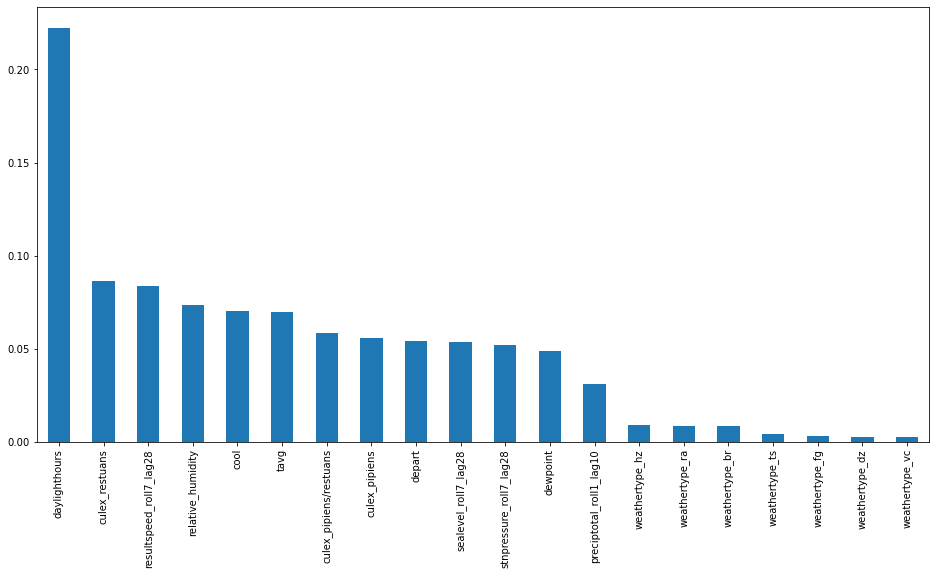

In [22]:
# Plot feature importance

plt.figure(figsize = (16,8))
forest_importances = pd.Series(importance, index= imp_features)
forest_importances.plot.bar();

The plot above shows the feature importance of the Random Forest model sorted in order of importance. 

Looking at the top 3 features:

daylighthours - supports our hypothesis that the day light hours affects mosquito activity levels, which increases the spread of WNV

culex_restuans - This is the species of mosquitos that have the highest rate of having WNV based on our data. They are known carriers of the virus.

resultspeed_roll7_lag28 - supports our hypothesis that past rainy season may cause mosquito outbreaks which increases the spread of WNV

<a id='ada'></a>
### Model 3: Adaptive Boosting Classifier

Adaptive Boosting is a boosting algorithm that combines multiple weak classifiers into a single strong classifier. It creates single split decision trees called decision stump; the decision of the trees will be weighted depending on its ability to classify the data. A benefit Adaptive Boost brings is that it allows us to capture some non-linear relationships. 
[Link](https://towardsdatascience.com/understanding-adaboost-2f94f22d5bfe)


#### Hyperparameters:

criterion -> The criterion of split

max_depth -> The maximum depth of the tree.

ccp_alpha -> Impurity threshold of each split.

class_weight -> Balance weights will add weights to the observations. The weights will be inversely proportion to their frequencies. This method deals penalizes the majority class, which helps for imbalanced classes.


From grid searching, we get the following parameters:

In [23]:
ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__ccp_alpha': 0,
 'base_estimator__class_weight': 'balanced',
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 15,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(ccp_alpha=0, class_weight='balanced', max_depth=15),
 'learning_rate': 1.0,
 'n_estimators': 200,
 'random_state': 25}

<a id='gb'></a>
### Model 4: Gradient Boosting Classifier

Gradient boost is similar to Adaboost, but the weights of the decision of the trees are dependent on some loss function. 
[Link]( https://towardsdatascience.com/understanding-gradient-boosting-machines-9be756fe76ab)


#### Hyperparameters:

criterion -> The criterion of split

max_depth -> The maximum depth of the tree.

loss -> The loss function to be optimized


From grid searching, we get the following parameters:

In [24]:
gb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'exponential',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_iter_no_change': None,
 'random_state': 25,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

<a id='nn'></a>
### Model 5: Neural Network - Multilayer Perceptron Classifier

MLPClassifier trains iteratively since at each time step the partial derivatives of the loss function with respect to the model parameters are computed to update the parameters.

It can also have a regularization term added to the loss function that shrinks model parameters to prevent overfitting.
[link](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

#### Hyperparameters:

learning_rate -> Learning rate schedule for weight updates.

validation_fraction -> The proportion of training data to set aside as validation set for early stopping.

hidden_layer_sizes -> The amount of nodes in the hidden layers


From grid searching, we get the following parameters:

In [25]:
nn.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': True,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 2000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 25,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.15,
 'verbose': 1,
 'warm_start': False}

<a id='selection'></a>
## Model Selection

In this section we will evaluate the results of the models and choose the ideal model.

After selecting the ideal hyperparameters from gridsearching, we generate the evaluation metrics for the models:

In [26]:
# Function to get evaluation metrics
def metrics(model,X_train,y_train,X_test,y_test):
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    print('Train Data Evaluation Score')
    print(f'AUCROC: {roc_auc_score(y_train,model.predict_proba(X_train)[:, 1])}')
    print('--------------')
    print('Test Data Evaluation Scores')
    print(f'AUCROC: {roc_auc_score(y_test,model.predict_proba(X_test)[:, 1])}')
    print(f'Sensitivity: {cm[1,1]/(cm[1,1]+cm[1,0])}')
    print(f'Precision: {cm[1,1]/(cm[1,1]+cm[0,1])}')
    print(f'F1_score: {f1_score(pred, y_test)}')
    print('--------------')
    print(f'Outcome values :\n True Positive : {cm[1,1]} \n False Negative: {cm[1,0]} \n False Positive: {cm[0,1]} \n True Negative : {cm[0,0]}')


In [27]:
print('Logistic Regression \n')
metrics(lr,X_train_sm,y_train_sm,X_holdout,y_holdout)
print('\nRandom Forest\n')
metrics(rf,X_train_sm,y_train_sm,X_holdout,y_holdout)
print('\nADA Boost \n')
metrics(ada,X_train_sm,y_train_sm,X_holdout,y_holdout)
print('\nGradient Boost \n')
metrics(gb,X_train_sm,y_train_sm,X_holdout,y_holdout)
print('\n Neural Network \n')
metrics(nn,X_train_sm,y_train_sm,X_holdout,y_holdout)

Logistic Regression 

Train Data Evaluation Score
AUCROC: 0.8199724185842145
--------------
Test Data Evaluation Scores
AUCROC: 0.7942192021707105
Sensitivity: 0.7898550724637681
Precision: 0.12124582869855395
F1_score: 0.210221793635487
--------------
Outcome values :
 True Positive : 109 
 False Negative: 29 
 False Positive: 790 
 True Negative : 1699

Random Forest

Train Data Evaluation Score
AUCROC: 0.9119886300886906
--------------
Test Data Evaluation Scores
AUCROC: 0.8317670212704014
Sensitivity: 0.7318840579710145
Precision: 0.15279878971255673
F1_score: 0.2528160200250313
--------------
Outcome values :
 True Positive : 101 
 False Negative: 37 
 False Positive: 560 
 True Negative : 1929

ADA Boost 

Train Data Evaluation Score
AUCROC: 0.9123487589672521
--------------
Test Data Evaluation Scores
AUCROC: 0.8370686091265336
Sensitivity: 0.7318840579710145
Precision: 0.15279878971255673
F1_score: 0.2528160200250313
--------------
Outcome values :
 True Positive : 101 
 False 

### Selected Model:

To select the best model, we consider the following factors:

##### 1) High Recall/Specificity:

The ideal model will have a high recall. We are interested in the positive class (WNV present), recall captures the proportion of positive classes predicted correctly by the model.

##### 2) Low ROCAUC difference between training and validation data: 

An ideal model will control for overfitting, if the ROC AUC score between the training and validation data is small, it implies that the model is not overfitted to the train data. ROC AUC score was used as the evaluation metrics of choice because we are training the data on data that is transformed by SMOTE. Accuracy, recall and other metrics that are prediction dependent may not be applicable as the validation data remains imbalanced.

The following is a table of our models and the evaluation metrics generated:

|  | Logistic Regression | Random Forest | ADA Boost | Gradient Boost | Neural Network |
|---|---|---|---|---|---|
| **Train ROC AUC** | 81.90% | 91.20% | 91.23% | 91.23% |87.54%|
| **ROC AUC** | 80.86% | 85.12% | 79.55% | 80.80% |86.13%|
| **Recall** | 79.71% | 87.68% | **97.10%** | 97.10% |88.41%|
| **Precision** | 12.29% | 13.12% | 9.65% | 9.96% |13.77%|
| **F1 score** | 21.30% | 22.83% | 17.55% | 18.06% |23.83%|

Our best model is the ADA Boost model. It achieves a recall of 97.10%, successfully predicting most of the WNV cases. A drawback of the model is that the precision is 9.65%. This is expected as we are using mainly weather data to predict whether a trap has west nile virus. This is problematic as not all traps will have west nile virus on a given day, but the same weather data will be used to predict all the traps. Hence, with our approach, we expect to see a low precision score. Suggestions on how to improve the model precision are stated in the [Future Work](#future) section

<a id='kaggle'></a>
## Kaggle Evaluation

In this section, we create submission files to upload on [Kaggle](https://www.kaggle.com/c/predict-west-nile-virus/overview). We re-train the models on the entire dataset to generate submission file of real-valued probability that WNV is present.

In [28]:
# Standard Scaler
fix_cols = [x for x in X.columns if x.startswith('culex') or x.startswith('weathertype') or x.startswith('wnvpresent')]
cols = [x for x in X.columns if x not in fix_cols]

ss = StandardScaler()
X_sc = X
for i in cols:
    X_sc.loc[:,i] = ss.fit_transform(X[[i]])
    X_test.loc[:,i] = ss.transform(X_test[[i]])

C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\chris\anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on 

In [29]:
# SMOTE
sm = SMOTE(random_state = 25)

X_sm, y_sm = sm.fit_resample(X, y)

In [30]:
#Selected model
model1 = lr
model2 = rf
model3 = ada
model4 = gb
model5 = nn
#Retrain model on full training set
model1.fit(X_sm,y_sm)
model2.fit(X_sm,y_sm)
model3.fit(X_sm,y_sm)
model4.fit(X_sm,y_sm)
model5.fit(X_sm,y_sm)

Iteration 1, loss = 0.61801138
Validation score: 0.726481
Iteration 2, loss = 0.54097648
Validation score: 0.765651
Iteration 3, loss = 0.50931410
Validation score: 0.778038
Iteration 4, loss = 0.49022102
Validation score: 0.774690
Iteration 5, loss = 0.47676643
Validation score: 0.783395
Iteration 6, loss = 0.46692781
Validation score: 0.788416
Iteration 7, loss = 0.46024542
Validation score: 0.790090
Iteration 8, loss = 0.45393043
Validation score: 0.796117
Iteration 9, loss = 0.44911583
Validation score: 0.793773
Iteration 10, loss = 0.44520466
Validation score: 0.791430
Iteration 11, loss = 0.44188939
Validation score: 0.801808
Iteration 12, loss = 0.43988144
Validation score: 0.794777
Iteration 13, loss = 0.43718172
Validation score: 0.802143
Iteration 14, loss = 0.43485799
Validation score: 0.802812
Iteration 15, loss = 0.43298526
Validation score: 0.805490
Iteration 16, loss = 0.43108279
Validation score: 0.807834
Iteration 17, loss = 0.42943538
Validation score: 0.806830
Iterat

MLPClassifier(early_stopping=True, learning_rate='adaptive', max_iter=2000,
              random_state=25, validation_fraction=0.15, verbose=1)

In [31]:
# Create submission file
models = [model1, model2, model3, model4, model5]
count = 0
for model in models:
    submission = pd.DataFrame()
    submission['Id'] = test_df['id']
    submission['WnvPresent'] = model.predict_proba(X_test)[:,1]
    count+=1
    submission.to_csv(f'../../datasets/submission{str(count)}.csv', index = False)

### Kaggle score:

Kaggle returns the AUCROC score of the test dataset:

Logistic Regression: 0.67515

Random Forest: 0.6628

Ada Boost: 0.66842

Gradient Boost: 0.65783

Neural Network: 0.62480

We observe a slight decrease in the ROCAUC scores in our models. This hints that our models are showing signs of overfitting on 2007, 2009, 2011, 2013 data (train dataset).

<a id='conclude'></a>
## Conclusions and Recommendations

In conclusion, the selected model performs sufficiently well as a screening tool, with a recall of 97.10% and validation AUC-ROC score of 66.84% (kaggle). However there is definitely room for improvement and fine-tuning. 

The strongest features from the modeling process revealed that the occurence of WNV is correlated to weather data which predict rainfall, which creates ideal conditions for mosquitos to  breed and amplify the spread of the WNV. Since the eggs take time to hatch, weather features which describe past weather data became powerful predictors. This leads us to recommend a two-step approach to mosquito control.

Spraying strategy involves 2 types of pesticides:
- Type 1: Targets the **larvae and pupae** and is applied directly onto containers/areas that may potentially accumulate stagnent water. This should be applied ahead of potential spikes in mosquito numbers.
- Type 2: Targets the **adult mosquito**, and is applied via aerosol spray at local clusters.
[Source: Central Mass Mosquito Control Project](https://www.cmmcp.org/pesticide-information/pages/products-we-use)

Spraying should be conducted during the summer months (between June - September), when weather conditions begin to favour mosquito breeding.

Spraying should cover a radius of at least 3 km as the main species Culex Pipiens has been studied to have a mean flight distance of 1.5km and maximum flight distance of 3km.
[Source: Dispersal of Adult Culex Mosquitoes in an Urban West Nile Virus Hotspot](https://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0002768)

<a id='future'></a>
### Future Work
The following suggestions may further improve on the model's precision but require additional data to proceed.

#### Include more localized environmental data besides weather
A major limitation of our model is that our inputs are based on average city-wide weather conditions. This does not allow us to predict localized mosquito clusters, making it difficult to narrow down our predictions to specific areas of interest. To overcome this limitation, we can include additional data which describe localized environmental features that could depict the extent of urbanization, or footfall/population density of the particular area etc.

#### Include more spray data
More spray data can be included to better evaluate the effectiveness of the current spraying strategy, and conduct a cost/benefit analysis for spraying to gain further insights on how to improve on the current programme.

#### Ensemble methods
We can combine the predictions from different models to incorporate the strengths of multiple models into our final model. For instance, AdaBoost gave the best sensitivity while Logistic Regression performed best in terms of minimal overfitting. By combining the predictions from these two models, we can create an encemble method which combines the benefits of using each.

In [32]:
#Ensemble method using 40% log-reg and 60% ada boost
ensemble_predictions =  0.4*(model1.predict_proba(X_test)[:,1]) + 0.6*(model3.predict_proba(X_test)[:,1])

In [33]:
# Create submission file
submission_ensemble = pd.DataFrame()
submission_ensemble['Id'] = test_df['id']
submission_ensemble['WnvPresent'] = ensemble_predictions

In [34]:
submission_ensemble.to_csv('../../datasets/submission_ensemble.csv', index = False)

The ensemble model scored an ROCAUC score of 0.70643 on the unseen Kaggle data. There is room for improvement for our models if more combination of ensemble methods are used.